https://github.com/JMoura10/Sistemas-Inteligentes

The following code predicts a quantitative measure of disease progression one year after baseline, using 10 baseline variables.
All the necessary libraries were imported at the beginning of the code for organisational and clarity purposes.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas

Having all the necessary libraries imported, the dataset to be used was loaded, and the 10 baseline variables and the target were identified.

In [2]:
# Load dataset
diabetes = datasets.load_diabetes(as_frame=True)
x = diabetes.data
y = diabetes.target.values

Before performing any type of modelling, it is extremely important to split the data into two different sets, one for training and the other for testing. While the training data will be used to build the model, the test data will be used to evaluate its performance. The test set is smaller than the training set so that most of the data could be used to train the model, but it has to be large enough to provide a reliable evaluation. In this case, 20% of the total data was used for testing. This step is crucial because the model should be tested on unseen data, which is data that was not used to build it. Otherwise, the model might appear perfect, and it would not reflect its real performance for new data.

In [3]:
# Splitting data into train and test
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

Since the features of the dataset were in different scales, standardisation was applied. This way, the data was transformed so that each feature has zero mean and unit variance, allowing a comparison between them.

In [4]:
# Standardise features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

After preparing the data, fuzzy c-means clustering was applied. This method partitioned the data into a pre-defined number of clusters, and each cluster corresponded to a rule that was later used on the TSK (Takagi-Sugeno) model.
The number of clusters and the parameter m, which controls how wide the membership function is, were tuned in order to reduce the MSE (Mean Squared Error), leading to a more reliable model.
The clustering returns, among other outputs, the centres and membership degrees of each cluster.

In [5]:
# Number of clusters 
n_clusters = 4
m=2

# Concatenate target for clustering
x_exp=np.concatenate([x_train, y_train.reshape(-1, 1)], axis=1)

# Transpose data for skfuzzy (expects features x samples)
x_exp_T = x_exp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    x_exp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)
centers.shape

(4, 11)

Then, the spread of each cluster, represented by sigma, was computed using the membership degrees as weights. These values were later used as parameters for the Gaussian formula in the TSK model.

In [6]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((x_exp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Once the fuzzy clustering was computed, a hard partition of the samples was obtained by assigning each point to the cluster where it had the highest membership degree. A scatter plot was also made, where the transparency of each point reflects its membership degree to the respective cluster.

Fuzzy partition coefficient (FPC): 0.780319261044535


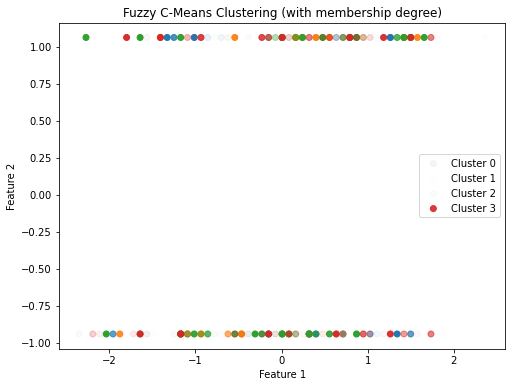

In [7]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        x_exp[cluster_labels == j, 0],             # Feature 1
        x_exp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

The aspect of the graph is explained by the nature of Feature 2. Since it represents the sex of the person, a binary feature, it only takes two values and the points align in two horizontal lines.

The next step was to plot the Gaussian membership function for each cluster, using its centre and spread. The resulting curves illustrate how the membership degree of each cluster varies across the range of the feature.

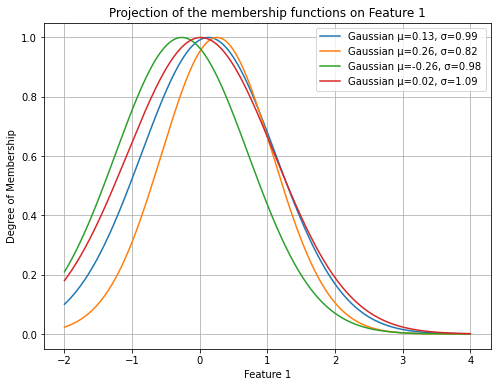

In [8]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0])) # only use centres and sigmas

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,0],2)}, σ={np.round(sigmas[j,0],2)}")

plt.title("Projection of the membership functions on Feature 1")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

The TSK model was implemented using information already computed before. In a TSK model, the overall output is a weighted average of the rule inputs. The antecedents of the model were represented by the Gaussian membership functions, characterised by the centres and spread of each cluster obtained from fuzzy c-means clustering. The consequents were defined as linear functions of the inputs, with each rule having its own coefficients for each input and a bias.

In [9]:
# Implementation of TSK
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs

The parameters for the antecedents and for the consequents were determined in distinct ways, using the hybrid ANFIS training method. The antecedent parameters were adjusted through gradient descent, with backward pass. The consequent parameters were optimised by solving a linear system using least squares. This hybrid approach allows a much faster convergence compared to the use of a single method.

In [10]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, x, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(x)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()

In [11]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, x, y):
    with torch.no_grad():
        _, norm_fs, _ = model(x)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([x, torch.ones(x.shape[0], 1)], dim=1)
        
        phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(x.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(phi, y).solution
        
        model.consequents.data = theta.reshape(model.consequents.shape)

In [12]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# updated version only has one for loop
# ---------------------------
def train_hybrid_anfis(model, x, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, x, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, x, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, x, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

The model was ready to be built, using the previously obtained results for the antecedents and consequents.

In [13]:
# Build model
model = TSK(n_inputs=x_train.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Having built the model, it was trained employing the hybrid ANFIS solution defined above.

In [14]:
# Training with Hybrid ANFIS:
train_hybrid_anfis(model, x_train, y_train.reshape(-1,1), max_iters=10, gd_epochs=20, lr=1e-4)

tensor(2355.3774, grad_fn=<MseLossBackward0>)
tensor(2354.8269, grad_fn=<MseLossBackward0>)
tensor(2354.2812, grad_fn=<MseLossBackward0>)
tensor(2353.7378, grad_fn=<MseLossBackward0>)
tensor(2353.1973, grad_fn=<MseLossBackward0>)
tensor(2352.6582, grad_fn=<MseLossBackward0>)
tensor(2352.1221, grad_fn=<MseLossBackward0>)
tensor(2351.5920, grad_fn=<MseLossBackward0>)
tensor(2351.0645, grad_fn=<MseLossBackward0>)
tensor(2350.5386, grad_fn=<MseLossBackward0>)
tensor(2350.0132, grad_fn=<MseLossBackward0>)
tensor(2349.4893, grad_fn=<MseLossBackward0>)
tensor(2348.9675, grad_fn=<MseLossBackward0>)
tensor(2348.4473, grad_fn=<MseLossBackward0>)
tensor(2347.9292, grad_fn=<MseLossBackward0>)
tensor(2347.4148, grad_fn=<MseLossBackward0>)
tensor(2346.9031, grad_fn=<MseLossBackward0>)
tensor(2346.3928, grad_fn=<MseLossBackward0>)
tensor(2345.8853, grad_fn=<MseLossBackward0>)
tensor(2345.3826, grad_fn=<MseLossBackward0>)
tensor(2344.5596, grad_fn=<MseLossBackward0>)
tensor(2344.0181, grad_fn=<MseLoss

Finally, the model was evaluated on the test set, and its performance was measured using the MSE and R². These metrics assessed how well the model's outputs matched the target values. 

In [15]:
y_pred, _, _=model(x_test)

mse = mean_squared_error(y_test.detach().numpy(),y_pred.detach().numpy())
print(f'MSE: {mse}')

r2 = r2_score(y_test.detach().numpy(), y_pred.detach().numpy())
print(f'R²: {r2}')

MSE: 2394.612548828125
R²: 0.548028682084819


Besides using the hybrid ANFIS to solve the regression problem, a neural network was also considered.

The data was already split into training and testing, so there was no further splitting was needed. Consequently, a six-layer neural network was defined, with 4 hidden layers of 64 neurons each, employing ReLU activation functions and dropout equal to 50%.

In [1003]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

The model was trained for 100 epochs, with a learning rate of 0.001, a dropout rate of 10% and a batch size of 64. These parameters were tuned to minimise the MSE.

In [1004]:
num_epochs=100
lr=1e-3
dropout=0.1
batch_size=64

The training features were wrapped into a dataset, to organise the data. Then, it was prepared to be fed to the model according to the batch size specified above, and the order of the samples was randomised.

In [1005]:
# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(x_train, y_train)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

The model was built with some variables previously chosen. Since it is a regression problem, the MSE was selected as the loss function, and an optimiser was employed to update the model parameters.

In [1006]:
# Model, Loss, Optimizer

model = MLP(input_size=x_train.shape[1], dropout_prob=dropout)
criterion = nn.MSELoss() #for regression
optimizer = optim.Adam(model.parameters(), lr=lr)

The model could finally be trained for the specified number of epochs. For each epoch, the training data was processed in batches with size also previously specified, the loss was computed and the model parameters were updated. The average loss was printed for each epoch, to allow the monitoring of the progress.

In [1007]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_dataloader:

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/100], Loss: 29660.9619
Epoch [2/100], Loss: 29788.9850
Epoch [3/100], Loss: 29586.0215
Epoch [4/100], Loss: 28792.2321
Epoch [5/100], Loss: 28863.2220
Epoch [6/100], Loss: 27873.9209
Epoch [7/100], Loss: 25634.7119
Epoch [8/100], Loss: 23130.8971
Epoch [9/100], Loss: 17325.6877
Epoch [10/100], Loss: 10680.4388
Epoch [11/100], Loss: 6457.1261
Epoch [12/100], Loss: 6276.6932
Epoch [13/100], Loss: 5502.5242
Epoch [14/100], Loss: 5063.7658
Epoch [15/100], Loss: 4659.9666
Epoch [16/100], Loss: 4274.6924
Epoch [17/100], Loss: 4240.8907
Epoch [18/100], Loss: 4313.2631
Epoch [19/100], Loss: 4115.6631
Epoch [20/100], Loss: 3838.8355
Epoch [21/100], Loss: 3862.3254
Epoch [22/100], Loss: 3594.5724
Epoch [23/100], Loss: 3888.8632
Epoch [24/100], Loss: 3666.7994
Epoch [25/100], Loss: 3621.1355
Epoch [26/100], Loss: 3669.9141
Epoch [27/100], Loss: 3457.9644
Epoch [28/100], Loss: 3551.3129
Epoch [29/100], Loss: 3538.7520
Epoch [30/100], Loss: 3607.4234
Epoch [31/100], Loss: 3423.1811
Epoch [

Lastly, the model was evaluated on the test set, and its performance was measured using the MSE and R². These metrics assessed how well the model's outputs matched the target values

In [1008]:
y_pred = model(x_test)

mse = mean_squared_error(y_test.detach().numpy(),y_pred.detach().numpy())
print(f'MSE: {mse}')

r2 = r2_score(y_test.detach().numpy(), y_pred.detach().numpy())
print(f'R²: {r2}')

MSE: 2985.1923828125
R²: 0.436559676241867


By analysing the resulting MSE for both models, it was possible to conclude that the hybrid ANFIS was the best option for this regression problem. However, if the characteristics of the problem change, such as the number of samples, it is not certain that the hybrid ANFIS will have a better performance than the neural network, as the performance of both models is dependent on the characteristics of the problem. For larger datasets, a neural network may provide a better generalisation due to being more flexible, while the hybrid ANFIS has a better interpretability and can perform better on small to medium datasets.